Importing the libraries

In [ ]:
# !pip install tensorflow==2.3.0
# !pip install keras==2.4.3
# !pip install pydot==1.4.2

# !pip install -q -U tensorflow-addons==0.13.0
# !pip install tensorflow_datasets
# !pip install ipywidgets

# !pip install jupyter
# !jupyter nbextension enable --py widgetsnbextension

import os
import random
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras import metrics

2021-08-09 08:13:57.989391: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-08-09 08:13:57.989432: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Loading the MNIST Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Creating the Distance Layer for the Model

In [ ]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

Defining the embedding model architecture

In [ ]:
def create_siamese_twin():
    """
    creates and returns an embedding model to be used in the siamese architecture
    """
    # Define the tensors for the two input images
    input_twin = Input(IMAGE_SHAPE)
    #x = brand_model(input_twin)
    x = Conv2D(3, (2, 2), activation="relu")(input_twin)
    x = MaxPooling2D()(x)
    # x = Conv2D(512, (2, 2), activation="relu")(x)
    # x = MaxPooling2D()(x)
    # x = Conv2D(256, (1, 1), activation="relu")(x)
    x = Flatten()(x)
    outputs = Dense(128, name="final_dense", activation=None)(x)
    return Model(input_twin, outputs)

Putting the whole network together

In [ ]:
def create_siamese_network():
    """
    creates and returns the final siamese architecture with the embedded model
    """
    middle_input = Input(IMAGE_SHAPE)
    left_input = Input(IMAGE_SHAPE)
    right_input = Input(IMAGE_SHAPE)
    twin = create_siamese_twin()
    
    distances = DistanceLayer()(twin(middle_input), twin(left_input), twin(right_input))
    
    model = Model(inputs=[middle_input, left_input, right_input], outputs=distances)
    return model

Defining the custom training loops

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
        # self.accuracy = SiameseNetworkAccuracy

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        # self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}  # add accuracy

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

def accuracy(y_true, y_pred):
    """
    returns the keras binary accuracy
    """
    return binary_accuracy(y_true, 1 - y_pred)

In [ ]:
# The image shape to be fed in the model
IMAGE_SHAPE = x_train.shape[1:]
print('IMAGE_SHAPE', IMAGE_SHAPE)

IMAGE_SHAPE (28, 28, 1)


Triplet Generation

In [ ]:
def shuffle_triplets(triplets):
    """
    returns the shuffled array of the triplets
    """
    triplets_len = list(range(len(triplets[0])))
    random.shuffle(triplets_len)
    triplets_shuffles = [triplets[0][triplets_len], triplets[1][triplets_len], triplets[2][triplets_len]]
    return triplets_shuffles

def create_triplets(images_set, label_set, num_pos, num_neg, test = False, validation_split = 0.7):
    """
    creates and splits all possible triplets for training and validation
    """
    left_images = []
    middle_images = []
    right_images = []
    
    set_labels = []

    for label in set(label_set):
        label_pos_ids = np.where(label_set == label)[0]
        label_neg_ids = np.where(label_set != label)[0]
        np.random.shuffle(label_pos_ids)
        np.random.shuffle(label_neg_ids)
        
        positive_examples = label_pos_ids[:num_pos]
        negative_examples = label_neg_ids[:num_neg]
        triplet_labels = list(itertools.product(positive_examples, positive_examples, negative_examples))

        for trp in triplet_labels:
            left_images.append(images_set[trp[0]])
            middle_images.append(images_set[trp[1]])
            right_images.append(images_set[trp[2]])
            set_labels.append(1.0)
    
    triplets, labels = [np.array(left_images), np.array(middle_images), np.array(right_images)], np.array(set_labels)
    triplets = shuffle_triplets(triplets)
    
    if test:
        return (triplets, labels)

    split_point = int(num_pos * num_pos * num_neg * len(set(label_set)) * 0.7)
    train_triplets, train_labels = [triplets[0][:split_point], triplets[1][:split_point], triplets[2][:split_point]], labels[:split_point]
    val_triplets, val_labels = [triplets[0][split_point:], triplets[1][split_point:], triplets[2][split_point:]], labels[split_point:]
    
    return (train_triplets, train_labels), (val_triplets, val_labels)  

In [ ]:
TRAIN_NUM_POS = 4 # Number of positive examples to consider per class
TRAIN_NUM_NEG = 9 # Number of negative examples to consider per class

TEST_NUM_POS = 3 # Number of positive examples to consider per class
TEST_NUM_NEG = 6 # Number of negative examples to consider per class

In [ ]:
# Storing the triplets
(train_triplets, train_labels), (val_triplets, val_labels)  = create_triplets(x_train, y_train, TRAIN_NUM_POS, TRAIN_NUM_NEG)
(test_triplets, test_labels) = create_triplets(x_test, y_test, TEST_NUM_POS, TEST_NUM_NEG, test= True)

In [ ]:
# Checking the shapes for the triplets
print("Train Triplets Shape: {}, Train Labels Shape: {}".format(np.array(train_triplets).shape, train_labels.shape))
print("Val Triplets Shape: {}, Val Labels Shape: {}".format(np.array(val_triplets).shape, val_labels.shape))
print("Test Triplets Shape: {}, Test Labels Shape: {}".format(np.array(test_triplets).shape, test_labels.shape))

Train Triplets Shape: (3, 1007, 28, 28, 1), Train Labels Shape: (1007,)
Val Triplets Shape: (3, 433, 28, 28, 1), Val Labels Shape: (433,)
Test Triplets Shape: (3, 540, 28, 28, 1), Test Labels Shape: (540,)


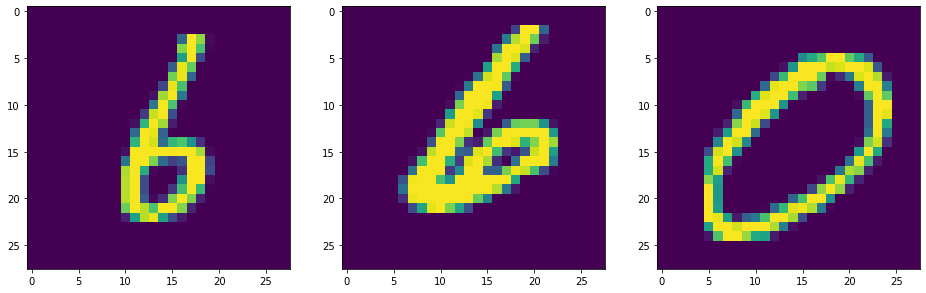

In [ ]:
# plotting some triplets 
num = np.random.randint(0, len(train_labels))
plt.figure(figsize= (16,15))
plt.subplot(1,3,1)
plt.imshow(train_triplets[0][num])
plt.subplot(1,3,2)
plt.imshow(train_triplets[1][num])
plt.subplot(1,3,3)
plt.imshow(train_triplets[2][num])

Creating the model

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_9 (Functional)       (None, 128)          65039       input_9[0][0]                    
                                                                 input_10[0][0]       

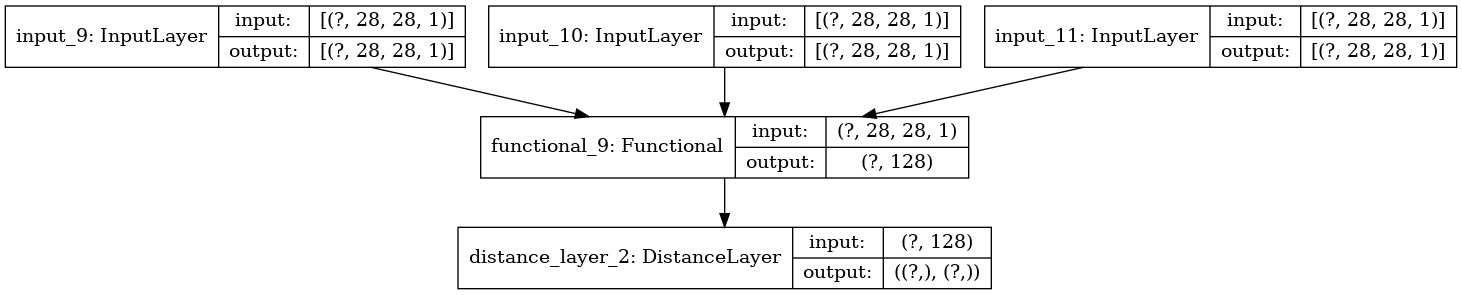

In [ ]:
siamese_network = create_siamese_network()
siamese_network.summary()
tf.keras.utils.plot_model(siamese_network, show_shapes = True)

Compiling the Model

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), metrics=accuracy)

Training the model

In [ ]:
siamese_model.fit((train_triplets, train_labels), validation_data= ((val_triplets, val_labels)), epochs = 10)

Epoch 1/10
32/32 [==============================] - 1s 24ms/step - loss: 0.8813 - val_loss: 0.4099
Epoch 2/10
32/32 [==============================] - 1s 22ms/step - loss: 0.3922 - val_loss: 0.2032
Epoch 3/10
32/32 [==============================] - 1s 22ms/step - loss: 0.1969 - val_loss: 0.1152
Epoch 4/10
32/32 [==============================] - 1s 28ms/step - loss: 0.1106 - val_loss: 0.0807
Epoch 5/10
32/32 [==============================] - 1s 24ms/step - loss: 0.0675 - val_loss: 0.0653
Epoch 6/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0483 - val_loss: 0.0554
Epoch 7/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0340 - val_loss: 0.0482
Epoch 8/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0240 - val_loss: 0.0418
Epoch 9/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0162 - val_loss: 0.0359
Epoch 10/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0099 - val_loss: 0.0311


In [ ]:
embedder = tf.keras.models.load_model('embedding_generator/')
embedder.summary()

2021-08-09 08:14:14.416660: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-09 08:14:14.416691: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-09 08:14:14.416715: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-f9d7a30a-760e-4df9-995d-bfc22963224f): /proc/driver/nvidia/version does not exist
2021-08-09 08:14:14.416905: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-09 08:14:14.433335: I tensorflow/core/platform/profile_utils/cpu_util

In [ ]:
x_train_embeddings = embedder.predict(x_train)

In [ ]:
from online_triplet_loss import _pairwise_distances

In [ ]:
distances=_pairwise_distances(embeddings=x_train_embeddings)

2021-08-09 08:14:38.647789: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 14400000000 exceeds 10% of free system memory.


KernelInterrupted: Execution interrupted by the Jupyter kernel.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f9d7a30a-760e-4df9-995d-bfc22963224f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>